# Redes Neuronales Convolucionales con PyTorch

"Aprendizaje profundo" es un término general que generalmente se refiere al uso de redes neuronales con múltiples capas que sintetizan la forma en que el cerebro humano aprende y toma decisiones. Una red neuronal convolucional es un tipo de red neuronal que extrae *características* de matrices de valores numéricos (a menudo imágenes) mediante la convolución de múltiples filtros sobre los valores de matriz para aplicar pesos e identificar patrones, como bordes, esquinas, etc. imagen. Las representaciones numéricas de estos patrones luego se pasan a una capa de red neuronal completamente conectada para asignar las características a clases específicas.

Hay varios marcos de trabajo comúnmente utilizados para crear CNN. En este cuaderno, crearemos una CNN de ejemplo simple usando PyTorch.

## Importar bibliotecas

Primero, instalemos e importemos las bibliotecas de PyTorch que necesitaremos.

In [1]:
%pip install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\salom\miniconda3\envs\soa-ml\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.9.0+cpu


## Explora los datos

En este ejercicio, entrenará un modelo de clasificación basado en CNN que puede clasificar imágenes de formas geométricas. Echemos un vistazo a las clases de forma que el modelo necesita identificar.

3 classes:
['circle', 'square', 'triangle']


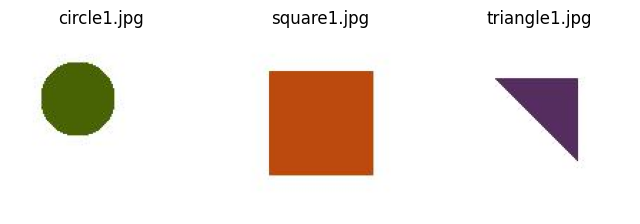

In [3]:
# Las imágenes están en la carpeta de datos/formas.
data_path = 'data/shapes/'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Mostrar la primera imagen de cada carpeta
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

## Cargar datos

PyTorch incluye funciones para cargar y transformar datos. Los usaremos para crear un cargador iterativo para datos de entrenamiento y un segundo cargador iterativo para datos de prueba (que usaremos para validar el modelo entrenado). Los cargadores transformarán los datos de la imagen en *tensores*, que son la estructura de datos central utilizada en PyTorch, y los normalizarán para que los valores de los píxeles estén en una escala con una media de 0,5 y una desviación estándar de 0,5.

Ejecute la siguiente celda para definir los cargadores de datos.

In [4]:
# Función para ingerir datos usando cargadores de entrenamiento y prueba
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Carga todas las imágenes, transformándolas.
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Dividir en conjuntos de datos de entrenamiento (70 % y de prueba (30 %))
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # definir un cargador para los datos de entrenamiento que podemos iterar en lotes de 50 imágenes
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # definir un cargador para los datos de prueba que podemos recorrer en lotes de 50 imágenes
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Obtenga los cargadores de datos iterativos para datos de prueba y entrenamiento
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


## Definir la CNN

En PyTorch, define un modelo de red neuronal como una clase que se deriva de la clase base **nn.Module**. Su clase debe definir las capas en su red y proporcionar un método de **reenvío** que se utiliza para procesar datos a través de las capas de la red.

In [5]:
#Crear una clase de red neuronal
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Nuestras imágenes son RGB, por lo que los canales de entrada = 3. Aplicaremos 12 filtros en la primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # Aplicaremos la agrupación máxima con un tamaño de kernel de 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # Una segunda capa convolucional toma 12 canales de entrada y genera 12 salidas
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # Una tercera capa convolucional toma 12 entradas y genera 24 salidas
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # Una capa de caída elimina el 20 % de las entidades para ayudar a evitar el sobreajuste
        self.drop = nn.Dropout2d(p=0.2)
        
        # Nuestros tensores de imagen de 128x128 se agruparán dos veces con un tamaño de kernel de 2. 128/2/2 es 32.
        # Así que nuestros tensores de características ahora son 32 x 32, y hemos generado 24 de ellos
        # Necesitamos aplanarlos y alimentarlos a una capa completamente conectada.
        # Mapearlas a la probabilidad para cada clase.
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use una función de activación de relu después de la capa 1 (convolución 1 y grupo)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use una función de activación de relu después de la capa 2 (convolución 2 y grupo)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Seleccione algunas funciones para colocarlas después de la tercera convolución para evitar el sobreajuste
        x = F.relu(self.drop(self.conv3(x)))
        
        # Solo elimina las funciones si se trata de un pase de entrenamiento
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Alimentar a la capa completamente conectada para predecir la clase
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


## Entrenar al modelo

Ahora que hemos definido una clase para la red, podemos entrenarla usando los datos de la imagen.

El entrenamiento consiste en una serie iterativa de pases hacia adelante en los que las capas de la red procesan los datos de entrenamiento en lotes, y el optimizador retrocede y ajusta los pesos. También usaremos un conjunto separado de imágenes de prueba para probar el modelo al final de cada iteración (o *época*) para que podamos realizar un seguimiento de la mejora del rendimiento a medida que avanza el proceso de capacitación.

En el siguiente ejemplo, usamos 5 épocas para entrenar el modelo usando los lotes de imágenes cargados por los cargadores de datos, reteniendo los datos en el cargador de datos de prueba para su validación. Después de cada época, una función de pérdida mide el error (*pérdida*) en el modelo y ajusta los pesos (que se generaron aleatoriamente para la primera iteración) para tratar de mejorar la precisión.

> **Nota**: Solo estamos usando 5 épocas para minimizar el tiempo de entrenamiento para este ejemplo simple. Una CNN del mundo real generalmente se entrena en más épocas que esta. El entrenamiento del modelo CNN requiere un uso intensivo del procesador, lo que implica muchas operaciones basadas en matrices y vectores; por lo que se recomienda realizar esto en un sistema que pueda aprovechar las GPU, que están optimizadas para este tipo de cálculo. Esto tardará un tiempo en completarse en un sistema basado en CPU: el estado se mostrará a medida que avanza el entrenamiento.

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    # Establecer el modelo en modo de entrenamiento
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Procesar las imágenes en lotes
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use la CPU o la GPU según corresponda
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Empuje los datos hacia adelante a través de las capas del modelo
        output = model(data)
        
        # Obtener la pérdida
        loss = loss_criteria(output, target)
        
        # Mantener un total acumulado
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Imprima métricas para cada 10 lotes para que veamos algún progreso
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # pérdida promedio de retorno para la época
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Cambie el modelo al modo de evaluación (para que no retropropaguemos ni descartemos)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Obtener las clases predichas para este lote
            output = model(data)
            
            # Calcule la pérdida para este lote
            test_loss += loss_criteria(output, target).item()
            
            # Calcule la precisión para este lote
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calcule la pérdida promedio y la precisión total para esta época
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # pérdida promedio de retorno para la época
    return avg_loss
    
    
# Ahora use las funciones de entrenamiento y prueba para entrenar y probar el modelo    

device = "cpu"
if (torch.cuda.is_available()):
    # si GPU está disponible, use cuda (en una CPU, ¡el entrenamiento tomará un tiempo considerable!)
    device = "cuda"
print('Training on', device)

# Cree una instancia de la clase de modelo y asígnela al dispositivo
model = Net(num_classes=len(classes)).to(device)

# Use un optimizador "Adam" para ajustar los pesos
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Especificar los criterios de pérdida
loss_criteria = nn.CrossEntropyLoss()

# Seguimiento de métricas en estas matrices
epoch_nums = []
training_loss = []
validation_loss = []

# Entrena más de 5 épocas (en un escenario real, probablemente usarías muchas más)
epochs = 5
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1


c:\Users\salom\miniconda3\envs\soa-ml\env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training set [0/840 (0%)] Loss: 1.100262
Training set [500/840 (59%)] Loss: 0.779556
Training set: Average loss: 0.849722
Validation set: Average loss: 0.466345, Accuracy: 289/360 (80%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.447420
Training set [500/840 (59%)] Loss: 0.402230
Training set: Average loss: 0.418575
Validation set: Average loss: 0.295248, Accuracy: 315/360 (88%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.274269
Training set [500/840 (59%)] Loss: 0.257050
Training set: Average loss: 0.262191
Validation set: Average loss: 0.170293, Accuracy: 343/360 (95%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.160912
Training set [500/840 (59%)] Loss: 0.131990
Training set: Average loss: 0.168246
Validation set: Average loss: 0.094241, Accuracy: 350/360 (97%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.084048
Training set [500/840 (59%)] Loss: 0.082696
Training set: Average loss: 0.100758
Validation set: Average loss: 0.057628, Accuracy: 356/360 (99%)



## Ver el historial de pérdidas

Hicimos un seguimiento de la pérdida promedio de entrenamiento y validación para cada época. Podemos graficarlos para verificar que la pérdida se redujo a medida que se entrenó el modelo y para detectar *sobreajuste* (que se indica por una caída continua en la pérdida de entrenamiento después de que la pérdida de validación se niveló o comenzó a aumentar).

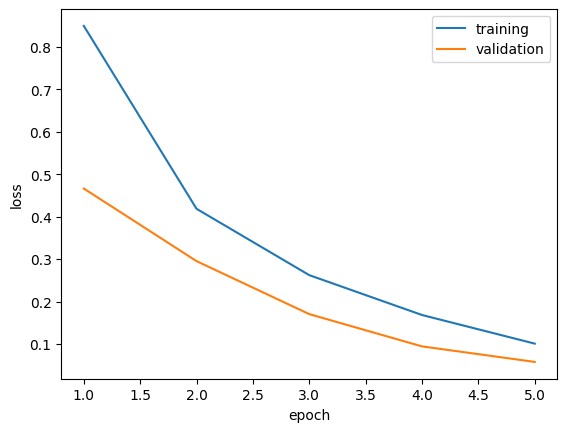

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluar el rendimiento del modelo

Puede ver la precisión final en función de los datos de prueba, pero normalmente querrá explorar las métricas de rendimiento con un poco más de profundidad. Tracemos una matriz de confusión para ver qué tan bien el modelo predice cada clase.

Getting predictions from test set...


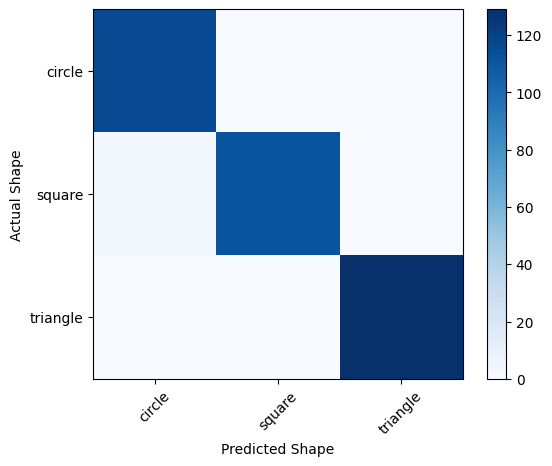

In [8]:
# Pytorch no tiene una métrica de matriz de confusión incorporada, por lo que usaremos SciKit-Learn
from sklearn.metrics import confusion_matrix

# Establecer el modelo para evaluar el modo
model.eval()

# Obtenga predicciones para los datos de prueba y conviértalos en matrices numpy para usar con SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Trazar la matriz de confusión
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Guardar el modelo entrenado

Ahora que ha entrenado un modelo de trabajo, puede guardarlo (incluidos los pesos entrenados) para usarlo más adelante.

In [9]:
# Guardar los pesos del modelo
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/shape_classifier.pt


## Usar el modelo entrenado

Ahora que hemos entrenado y evaluado nuestro modelo, podemos usarlo para predecir clases para nuevas imágenes.

circle


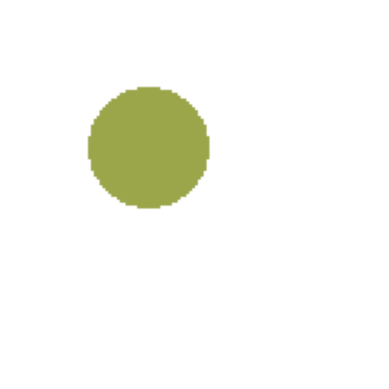

In [10]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Función para predecir la clase de una imagen.
def predict_image(classifier, image):
    import numpy
    
    # Establecer el modelo clasificador en modo de evaluación
    classifier.eval()
    
    # Aplica las mismas transformaciones que hicimos para las imágenes de entrenamiento.
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Agregue una dimensión de lote adicional ya que pytorch trata todas las entradas como lotes
    image_tensor = image_tensor.unsqueeze_(0)

    # Convierta la entrada en una variable
    input_features = Variable(image_tensor)

    # Predecir la clase de la imagen.
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Función para crear una imagen aleatoria (de un cuadrado, círculo o triángulo)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Crear una imagen de prueba aleatoria
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Mostrar la imagen
plt.axis('off')
plt.imshow(img)

# Cree una nueva clase de modelo y cargue los pesos guardados
model = Net()
model.load_state_dict(torch.load(model_file))

# Llamar a la función de predicción
index = predict_image(model, img)
print(classes[index])

## Otras lecturas

Para obtener más información sobre el entrenamiento de redes neuronales convolucionales con PyTorch, consulte la [documentación de PyTorch] (https://pytorch.org/).

## Desafío: clasificación de imágenes de Safari

Esperamos que este cuaderno le haya mostrado los pasos principales para entrenar y evaluar una CNN. ¿Por qué no pones en práctica lo que has aprendido con nuestro desafío de clasificación de imágenes de Safari en el cuaderno [/challenges/05 - Safari CNN Challenge.ipynb](./challenges/05%20-%20Safari%20CNN%20Challenge.ipynb)?

> **Nota**: El tiempo para completar este desafío opcional no está incluido en el tiempo estimado para este ejercicio. ¡Puedes dedicarle el tiempo que quieras!